In [53]:
import sklearn
import io
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from sklearn import linear_model
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor,Pool,cv
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
from datetime import datetime


### Read data

In [2]:
df = pd.read_csv('listings.csv') 
df = shuffle(df,random_state=0)
print(df.shape)

C:\Users\xu47s\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(59881, 96)


In [3]:
one_hot_col_names = ['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
           'neighbourhood_cleansed', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'instant_bookable', 
           'is_business_travel_ready', 'cancellation_policy','require_guest_profile_picture', 'require_guest_phone_verification','calendar_updated']
features = ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 
      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',     
      'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 
      'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
      'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']
 
price_features = ['security_deposit', 'cleaning_fee', 'extra_people','price'] 

text_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 
             'interaction', 'house_rules', 'host_name', 'host_about']

date_cols = ['host_since', 'first_review', 'last_review']

print("selected feature number ：",len(one_hot_col_names)+len(features)+len(price_features)+len(date_cols)+len(text_cols))
print("non-text feature number : ",len(one_hot_col_names)+len(features)+len(price_features)+len(date_cols))
print("continuous feature number : ",len(features)+len(price_features))
print("text feature number : ",len(text_cols))

selected feature number ： 62
non-text feature number :  50
continuous feature number :  30
text feature number :  12


# Data Clean

In [4]:
def clean_date(cols):
    num_data = cols.shape[0]
    #print(num_data)
    dates = pd.to_datetime(cols)
    min_date = pd.to_datetime(date.today())
    for col in dates:
        if not isinstance(col, float):
            min_date = min(min_date, col)
    mean_date = dates.mean()
    
    dif = pd.to_timedelta([mean_date - min_date]).astype('timedelta64[h]')[0]
    arr = np.zeros((num_data, 1))
    for i, col in enumerate(dates):
        arr[i] = pd.to_timedelta([col - min_date]).astype('timedelta64[h]')[0]
        if np.isnan(arr[i]):
            arr[i] = dif

    # print (np.min(arr), np.max(arr))
    return arr

In [5]:
def clean_host_response_rate(host_response_rate, num_data):
    total = 0
    count = 0
    for col in host_response_rate:
        if not isinstance(col, float):
            total += float(col.strip('%'))
            count += 1

    arr = np.zeros(num_data)
    mean = total / count
    print (host_response_rate.name, 'mean is ', mean)
    for i, col in enumerate(host_response_rate):
        if not isinstance(col, float):
            arr[i] += float(col.strip('%'))
        else:
            assert(math.isnan(col))
            arr[i] = mean
    return arr

In [6]:
def clean_price(price, num_data):
    '''
    total = 0
    count = 0
    all_count=0
    for col in price:
        all_count+=1
        if not isinstance(col, float):
            total += float(col.strip('$').replace(',', ''))
            count += 1
    
    
    mean = total / count
    print (price.name, 'mean is ', mean)
    print(all_count-count)
    '''
    arr = np.zeros(num_data)
    for i, col in enumerate(price):
        if not isinstance(col, float):
            arr[i] += float(col.strip('$').replace(',', ''))
        else:
            assert(math.isnan(col))
            arr[i] = 0
    return arr

In [7]:
def check_nan(cols):
    for col in cols:
        #print (col)
        if np.isnan(col):
            return True
    return False

In [8]:
def to_np_array_fill_NA_mean(cols):
    print (cols.name, 'mean is ', np.nanmean(np.array(cols)))
    return np.array(cols.fillna(np.nanmean(np.array(cols))))

In [9]:
num_data = df.shape[0]
# if check_nan(df['host_response_rate']):
'''
features = ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 
      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',     
      'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 
      'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
      'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']

'''
          
#price_features = ['security_deposit', 'cleaning_fee', 'extra_people','price'] 
arr = np.zeros((len(features) + len(price_features) + 1, num_data))
# check_nan(df['extra_people'])
print("1:",arr.shape)
host_response_rate = clean_host_response_rate(df['host_response_rate'], num_data)
print("2:",host_response_rate,host_response_rate.shape,len(host_response_rate))
print(arr[0])
arr[0] = host_response_rate
print("num_data", num_data)
i = 0
for feature in features:
    i += 1
    if check_nan(df[feature]):
        arr[i] = to_np_array_fill_NA_mean(df[feature])
    else:
        arr[i] = np.array(df[feature])
    

for feature in price_features:
    i += 1
    arr[i] = clean_price(df[feature], num_data)

label = arr[-1]
arr = arr[:-1].T
#arr = arr.T
print(arr.shape)
print("label:",len(label),label)

1: (31, 59881)
host_response_rate mean is  91.81647347518647
2: [100.          60.          91.81647348 ... 100.         100.
 100.        ] (59881,) 59881
[0. 0. 0. ... 0. 0. 0.]
num_data 59881
host_listings_count mean is  8.456983949359477
host_total_listings_count mean is  8.456983949359477
bathrooms mean is  1.108602959618761
bedrooms mean is  1.087790279705081
beds mean is  1.671634284947949
square_feet mean is  383.66568483063327
review_scores_rating mean is  92.82449394024498
review_scores_accuracy mean is  9.574485115957078
review_scores_cleanliness mean is  9.203351713698778
review_scores_checkin mean is  9.688236058191894
review_scores_communication mean is  9.719251568245728
review_scores_location mean is  9.59474379234949
review_scores_value mean is  9.273250779355733
reviews_per_month mean is  1.163733144822638
(59881, 30)
label: 59881 [50. 70. 69. ... 50. 78. 30.]


# Categorical features (one-hot)

In [15]:
def one_hot(arr):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arr)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [16]:
# use one-hot on host_verification
def host_verification(cols):
    possible_words = {}
    i = 0
    for col in cols:
        words = col.split()
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '' and wr not in possible_words:
                possible_words[wr] = i
                i += 1
    print (possible_words)
    l = len(possible_words)

    new_cols = np.zeros((cols.shape[0], l))
    for i, col in enumerate(cols):
        words = col.split()
        arr = np.zeros(l)
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '':
                arr[possible_words[wr]] = 1
        new_cols[i] = arr
    return new_cols

In [17]:
# use one-hot on amenities
def amenities(cols):
    dic = {}
    i = 0
    for col in cols:
        arr = col.split(',')
        for a in arr:
            ar = re.sub(r'\W+', '', a)
            if len(ar) > 0:
                if ar not in dic:
                    dic[ar] = i
                    i += 1
    
    l = len(dic)
    new_cols = np.zeros((cols.shape[0], l))
    for i, col in enumerate(cols):
        words = col.split(',')
        arr = np.zeros(l)
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '':
                arr[dic[wr]] = 1
        new_cols[i] = arr
    return new_cols

# using one-hot

In [21]:
one_hot_col_names = ['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
           'neighbourhood_cleansed', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'instant_bookable', 
           'is_business_travel_ready', 'cancellation_policy','require_guest_profile_picture', 'require_guest_phone_verification','calendar_updated']

one_hot_dict = {}
for i in one_hot_col_names:    
    one_hot_dict[i] = one_hot(np.array(df[i].fillna(""), dtype=str))    #apply one-hot
#     one_hot_dict[i] = np.array(df[i].fillna(""), dtype=str)
# print(one_hot)
one_hot_dict['host_verifications'] = host_verification(df['host_verifications'])
one_hot_dict['amenities'] = amenities(df['amenities'])
# one_hot_dict['host_verifications'] = df['host_verifications']
# one_hot_dict['amenities'] = df['amenities']


{'email': 0, 'phone': 1, 'reviews': 2, 'jumio': 3, 'offline_government_id': 4, 'government_id': 5, 'work_email': 6, 'facebook': 7, 'sent_id': 8, 'selfie': 9, 'identity_manual': 10, 'google': 11, 'manual_online': 12, 'manual_offline': 13, 'zhima_selfie': 14, 'kba': 15, 'None': 16, 'weibo': 17, 'photographer': 18, 'sesame': 19, 'sesame_offline': 20}


In [ ]:
print(df['host_verifications'])
print(df['amenities'])

In [ ]:
print(one_hot_dict['host_verifications'])
print(one_hot_dict['amenities'])

In [22]:
ont_hot_list = []
# num = 0
for i in one_hot_dict.keys():
#     num += 1
    if 1<one_hot_dict[i].shape[1]<400:
        ont_hot_list.append(one_hot_dict[i])
#         print(i,one_hot_dict[i].shape[1])
# print(np.array(ont_hot_list).shape)

onehot_features = np.concatenate(ont_hot_list, axis=1)
# onehot_features = np.array(ont_hot_list).T
print(onehot_features.shape)
# print(len(one_hot_dict))

(59881, 351)


# Date features

In [10]:
date_features = []
for i in date_cols:
    date_features.append(clean_date(df[i]))

date_features = np.concatenate(date_features, axis=1)
date_features.shape

(59881, 3)

# Text features

In [11]:

#tf-idf
count_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2))

text_X_list = []
#text_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_name', 'host_about']

mask = label > 0
x = count_vect.fit_transform(df['description'][mask].values.astype('U'))
svd = TruncatedSVD(n_components=300)#x.shape[1]//100) #PCA(n_components=10)
text_X_list = svd.fit_transform(x)
text_features_unfiltered = np.array(text_X_list)
print(text_features_unfiltered.shape)


(59870, 300)


# LightGBM

In [23]:
mask = label > 0 
import lightgbm as lgb
from sklearn import metrics
arr_filtered = (arr[mask])
# print(arr_filtered.shape)  #(59870,30)
one_hot_filtered = onehot_features[mask]
#date_filtered = date_features[mask]   

num_data = arr_filtered.shape[0]
train_num = int(num_data * 0.7)
dev_num = int(num_data * 0.9)
test_num = num_data - train_num

label_filtered =np.log(label[mask])

train_label = label_filtered[:train_num]
dev_label = label_filtered[train_num:dev_num]
test_label = label_filtered[dev_num:]

print(test_label)
need_normalize = True
#arr
train_features_arr = arr_filtered[:train_num]
dev_features_arr = arr_filtered[train_num:dev_num]
test_features_arr = arr_filtered[dev_num:]
if need_normalize:
    mean = np.mean(train_features_arr,axis=0)
    std = np.std(train_features_arr,axis=0)
    train_features_arr = (train_features_arr - mean) / std
    dev_features_arr = (dev_features_arr - mean) / std
    test_features_arr =  (test_features_arr- mean) / std

#1hot
train_features_1h = one_hot_filtered[:train_num]
dev_features_1h = one_hot_filtered[train_num:dev_num]
test_features_1h = one_hot_filtered[dev_num:]

#txt 
train_features_txt = text_features_unfiltered[:train_num]
dev_features_txt = text_features_unfiltered[train_num:dev_num]
test_features_txt = text_features_unfiltered[dev_num:]
if need_normalize:
    mean = np.mean(train_features_txt,axis=0)
    std = np.std(train_features_txt,axis=0)
    train_features_txt = (train_features_txt - mean) / std
    dev_features_txt = (dev_features_txt - mean) / std
    test_features_txt =  (test_features_txt- mean) / std

# non-text features
train_nontext_feature = np.concatenate([train_features_arr, train_features_1h], axis=1)

val_nontext_feature = np.concatenate([dev_features_arr, dev_features_1h], axis=1)

test_nontext_feature = np.concatenate([test_features_arr, test_features_1h], axis=1)

# all features
train_features = np.concatenate([train_nontext_feature, train_features_txt],axis=1)

dev_features = np.concatenate([val_nontext_feature, dev_features_txt],axis=1)

test_features = np.concatenate([test_nontext_feature, test_features_txt],axis=1)

# starttime = datetime.datetime.now()



print(train_features.shape)
print(dev_features.shape)
print(test_features.shape)


[5.01063529 4.09434456 5.27299956 ... 3.91202301 4.35670883 3.40119738]
(41909, 681)
(11974, 681)
(5987, 681)


0.04211639266513097 0.09450858809297122 0.0958293107840789 0.8940451960509108 0.7613695421526888 0.761150209259636
train score :  0.8940451960509108
test score :  0.761150209259636
train mse :  0.04211639266513097
test mse :  0.0958293107840789
Run time :  24


Text(0, 0.5, 'Predicted label')

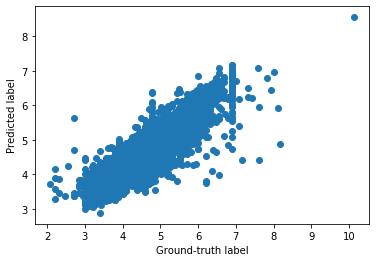

In [54]:
model=lgb.LGBMRegressor(objective='regression',num_leaves=50,
                      learning_rate=0.07, n_estimators=464, max_depth=6)
starttime  = datetime.now()
model.fit(train_features,train_label)
endtime  = datetime.now()
train_predict = model.predict(train_features)
dev_predict = model.predict(dev_features)
test_predict = model.predict(test_features)

mse_train = sklearn.metrics.mean_squared_error(train_label, train_predict)
mse_dev = sklearn.metrics.mean_squared_error(dev_label, dev_predict)
mse_test = sklearn.metrics.mean_squared_error(test_label, test_predict)

r2_train = sklearn.metrics.r2_score(train_label, train_predict)
r2_dev = sklearn.metrics.r2_score(dev_label, dev_predict)
r2_test = sklearn.metrics.r2_score(test_label, test_predict)

print(mse_train,mse_dev,mse_test,r2_train,r2_dev,r2_test)

print('train score : ',model.score(train_features, train_label))
print('test score : ',model.score(test_features, test_label))
print('train mse : ', mse_train)
print('test mse : ', mse_test)
print("Run time : ",(endtime - starttime).seconds)
plt.scatter(dev_label, dev_predict)
plt.xlabel('Ground-truth label')
plt.ylabel('Predicted label')